In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

CSV_PATH = "../Data/BRFSS_2024.csv"
TARGET = "DIABETE4"
VALID_TARGET_CLASSES = {1, 3, 4}

# Hyperparameters for tuning
mrt = 0.30      # Missing Rate Threshold
tau = 0.6       # Statistical importance threshold
n = 50          # Fallback: minimum number of features to retain
C = 0.2         # L1 regularization strength

## Data Cleaning and Feature Extraction

In [2]:
def load_brfss(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path, low_memory=False)
    df.columns = [c.strip().upper() for c in df.columns]
    return df

df = load_brfss(CSV_PATH)

if TARGET not in df.columns:
    raise KeyError(f"Target column {TARGET} not found in dataset.")

df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce")
df = df[df[TARGET].isin(VALID_TARGET_CLASSES)].copy()
df.dropna(subset=[TARGET], inplace=True)

print(df.shape, "after target filtering (keep 1/3/4; drop 2/7/9/NA)")
df[TARGET].value_counts(dropna=False).sort_index()

(453241, 301) after target filtering (keep 1/3/4; drop 2/7/9/NA)


DIABETE4
1.0     65809
3.0    376125
4.0     11307
Name: count, dtype: int64

In [3]:
SENTINEL_PATTERNS = [
    re.compile(r"^7+$"),
    re.compile(r"^9+$"),
]

def is_sentinel(x) -> bool:
    if pd.isna(x): 
        return True
    s = str(x).strip().lower()
    if s in {"", "nan", "none", "refused", "don’t know", "don't know"}:
        return True
    return any(p.fullmatch(s) for p in SENTINEL_PATTERNS)

def effective_missing_rate(series: pd.Series) -> float:
    return series.map(is_sentinel).mean()

missing_rates = df.drop(columns=[TARGET]).apply(effective_missing_rate)
to_keep = missing_rates[missing_rates <= mrt].index.tolist()

print(f"Keeping {len(to_keep)} / {len(df.columns)-1} columns (≤ {int(mrt*100)}% missing)")

Keeping 122 / 300 columns (≤ 30% missing)


In [4]:
for col in to_keep:
    df[col] = df[col].where(~df[col].map(is_sentinel), np.nan)
    df[col] = pd.to_numeric(df[col])

categorical_cols, continuous_cols = [], []
for col in to_keep:
    nunique = df[col].nunique(dropna=True)
    if pd.api.types.is_numeric_dtype(df[col]):
        if nunique <= 15:
            categorical_cols.append(col)
        else:
            continuous_cols.append(col)
    else:
        categorical_cols.append(col)

print(f"Categorical: {len(categorical_cols)}, Continuous: {len(continuous_cols)}")

Categorical: 96, Continuous: 26


In [5]:
y = df[TARGET].astype(int)
cat_results, cont_results = [], []

for col in categorical_cols:
    sub = df[[col, TARGET]].dropna()
    if sub.empty:
        continue
    tbl = pd.crosstab(sub[col], sub[TARGET])
    if tbl.shape[0] < 2 or tbl.shape[1] < 2:
        continue
    try:
        chi2_stat, p, dof, exp = stats.chi2_contingency(tbl, correction=False)
        cat_results.append({"feature": col, "p_value": p, "test": "chi2"})
    except Exception:
        pass

for col in continuous_cols:
    sub = df[[col, TARGET]].dropna()
    if sub.empty:
        continue
    groups = [sub.loc[sub[TARGET]==cls, col] for cls in sorted(VALID_TARGET_CLASSES)]
    try:
        fstat, p = stats.f_oneway(*groups)
        cont_results.append({"feature": col, "p_value": p, "test": "anova"})
    except Exception:
        try:
            stat, p = stats.kruskal(*groups, nan_policy="omit")
            cont_results.append({"feature": col, "p_value": p, "test": "kruskal"})
        except Exception:
            pass

all_results = pd.concat([pd.DataFrame(cat_results), pd.DataFrame(cont_results)], ignore_index=True)
all_results.dropna(inplace=True)
all_results.sort_values("p_value", inplace=True)

print("Top 20 variables by p-value:")
display(all_results.head(20))

Top 20 variables by p-value:


,feature,p_value,test
13,CHECKUP1,0.0,chi2
11,PERSDOC3,0.0,chi2
14,EXERANY2,0.0,chi2
15,LASTDEN4,0.0,chi2
10,PRIMINS2,0.0,chi2
9,GENHLTH,0.0,chi2
28,EDUCA,0.0,chi2
31,VETERAN3,0.0,chi2
25,CHCKDNY2,0.0,chi2
26,HAVARTH4,0.0,chi2


Selected 78 features with importance_norm ≥ 0.60
Top few selected features: ['CHECKUP1', 'PERSDOC3', 'EXERANY2', 'LASTDEN4', 'PRIMINS2', 'GENHLTH', 'EDUCA', 'VETERAN3', 'CHCKDNY2', 'HAVARTH4']
Final shape: (453241, 79)


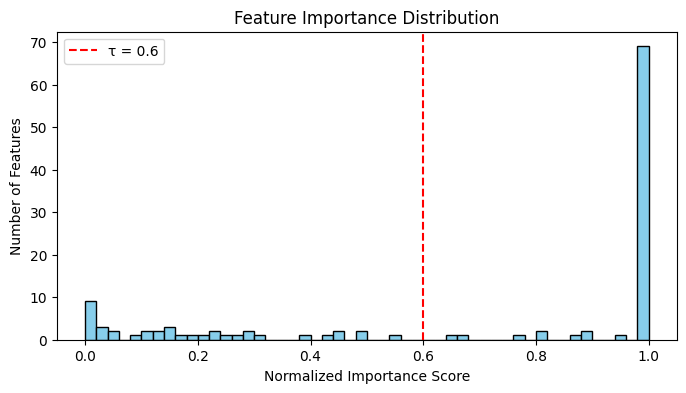

In [6]:
all_results["importance_score"] = -np.log10(all_results["p_value"].clip(lower=1e-300))

all_results["importance_norm"] = (
    all_results["importance_score"] - all_results["importance_score"].min()
) / (all_results["importance_score"].max() - all_results["importance_score"].min())

selected_by_tau = all_results[all_results["importance_norm"] >= tau]["feature"].tolist()

if len(selected_by_tau) < n:
    selected_by_tau = all_results.head(n)["feature"].tolist()

print(f"Selected {len(selected_by_tau)} features with importance_norm ≥ {tau:.2f}")
print("Top few selected features:", selected_by_tau[:10])

final_features = selected_by_tau + [TARGET]
df_cleaned = df[final_features].copy()

print("Final shape:", df_cleaned.shape)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(all_results["importance_norm"], bins=50, color="skyblue", edgecolor="black")
plt.axvline(tau, color="red", linestyle="--", label=f"τ = {tau}")
plt.xlabel("Normalized Importance Score")
plt.ylabel("Number of Features")
plt.title("Feature Importance Distribution")
plt.legend()
plt.show()

In [7]:
viz_path = "../Results/BRFSS_2024_visualization.csv"
df_cleaned.to_csv(viz_path, index=False)

## Feature Encoding

In [7]:
def detect_feature_types(df: pd.DataFrame, target: str = "DIABETE4") -> tuple[list, list, list]:
    codebook_ordinals = {
        "GENHLTH", "EDUCA", "_EDUCAG", "INCOME3", "_INCOMG1",
        "_BMI5CAT", "SLEPTIM1", "AGE5YR", "_AGEG5YR", "_AGE80",
        "_AGE65YR", "_AGE_G", "CHECKUP1", "POORHLTH",
        "PHYSHLTH", "MENTHLTH", "EMPLOY1", "MARITAL", "RENTHOM1"
    }

    dynamic_ordinals = []
    categorical_cols = []
    continuous_cols = []

    for col in df.columns:
        if col == target:
            continue

        series = df[col]
        if not pd.api.types.is_numeric_dtype(series):
            categorical_cols.append(col)
            continue

        nunique = series.nunique(dropna=True)
        if nunique < 2:
            continue

        unique_vals = np.sort(series.dropna().unique())

        if (
            2 <= nunique <= 15
            and np.issubdtype(series.dtype, np.number)
            and np.all(np.mod(unique_vals, 1) == 0)
        ):
            minv, maxv = int(unique_vals.min()), int(unique_vals.max())
            contiguous = set(range(minv, maxv + 1))
            actual = set(unique_vals.astype(int))
            if len(contiguous - actual) <= 2:
                dynamic_ordinals.append(col)
            else:
                categorical_cols.append(col)
        elif nunique <= 15:
            categorical_cols.append(col)
        else:
            continuous_cols.append(col)

    ordinal_cols = sorted(set(codebook_ordinals).union(dynamic_ordinals).intersection(df.columns))
    categorical_cols = [c for c in categorical_cols if c not in ordinal_cols]
    continuous_cols = [c for c in continuous_cols if c not in ordinal_cols]

    print(
        f"Detected {len(ordinal_cols)} ordinal, "
        f"{len(categorical_cols)} categorical, "
        f"{len(continuous_cols)} continuous columns."
    )
    return ordinal_cols, categorical_cols, continuous_cols


In [8]:
ordinal_cols, categorical_cols, continuous_cols = detect_feature_types(df_cleaned, target=TARGET)

Detected 40 ordinal, 31 categorical, 7 continuous columns.


In [9]:
ordinal_categories = []
for col in ordinal_cols:
    cats = sorted(df_cleaned[col].dropna().unique())
    ordinal_categories.append(cats)

print(f"Encoding {len(ordinal_cols)} ordinal, {len(categorical_cols)} categorical, {len(continuous_cols)} continuous columns")

preprocess = ColumnTransformer(
    transformers=[
        ("ord", Pipeline(steps=[
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ordenc", OrdinalEncoder(
                categories=ordinal_categories,
                handle_unknown="use_encoded_value",
                unknown_value=-1
            ))
        ]), ordinal_cols),

        ("cat", Pipeline(steps=[
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), categorical_cols),

        ("num", Pipeline(steps=[
            ("imp", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), continuous_cols)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

X = df_cleaned.drop(columns=[TARGET])
y = df_cleaned[TARGET].astype(int)

X_proc = preprocess.fit_transform(X)
feature_names = preprocess.get_feature_names_out()

df_encoded = pd.DataFrame(X_proc, columns=feature_names)
df_encoded[TARGET] = y.values

print("Encoded dataset shape:", df_encoded.shape)

Encoding 40 ordinal, 31 categorical, 7 continuous columns
Encoded dataset shape: (453241, 201)


## L1 Regularization

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = df_encoded.drop(columns=[TARGET])
y = df_encoded[TARGET]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

nonzero_counts = []
val_scores = []

print("Running L1-regularized Logistic Regression...\n")

model = LogisticRegression(
    penalty='l1',
    solver='saga',
    C=C,
    max_iter=5000,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)
score = model.score(X_val, y_val)
val_scores.append(score)

n_nonzero = np.sum(model.coef_ != 0)
nonzero_counts.append(n_nonzero)
print(f"C={C:.4f} | Val Acc={score:.4f} | Features Kept={n_nonzero}")

Running L1-regularized Logistic Regression...

C=0.2000 | Val Acc=0.8360 | Features Kept=266


In [11]:
coef_mask = np.any(model.coef_ != 0, axis=0)
selected_features = X.columns[coef_mask]

print(f"Selected {len(selected_features)} encoded features.")

final_cols = selected_features.tolist() + [TARGET]
df_final_encoded = df_encoded[final_cols].copy()

out_path = "../Results/BRFSS_2024_model_ready.csv"
df_final_encoded.to_csv(out_path, index=False)

Selected 162 encoded features.
